In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, RBF
from mbbo.output import format_for_submission
from mbbo.functions import get_function_data, FunctionInfo

Text(0.5, 0, 'Output')

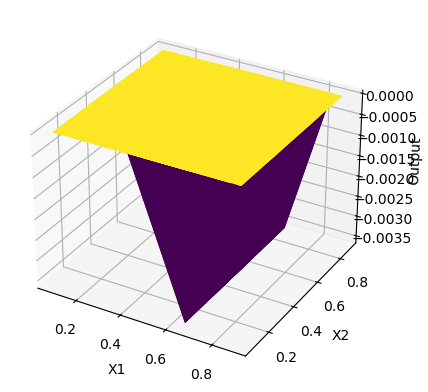

In [2]:
#mesh plot
ary1_in = np.load('../data/raw/initial_data/function_1/initial_inputs.npy')
ary1_out = np.load('../data/raw/initial_data/function_1/initial_outputs.npy')

x = ary1_in[:, 0]
y = ary1_in[:, 1]

X, Y = np.meshgrid(x, y)

# Reshape the output to fit the meshgrid layout for the surface plot
Z = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        Z[j, i] = ary1_out[i]  


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Surface plot
ax.plot_surface(X, Y, Z, cmap='viridis')

# Set labels
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Output')

In [ ]:
random.seed(51)
np.random.seed(51)


In [3]:
#Output to CSV
interim_folder = '../data/interim'
for i in range(1,9):
    ary_in, ary_out = get_function_data(i)
    combined = np.append(ary_in, ary_out.reshape(-1,1), axis=1)
    np.savetxt(f'{interim_folder}/function_{i}.csv', combined, delimiter=',')



In [4]:
def scale_f1(values):
    # Step 1: Replace zeros with a small positive value to avoid log(0)
    epsilon = 1e-200  # A very small number
    values_safe = np.where(values == 0, epsilon, values)

    # Step 2: Take the logarithm of absolute values
    log_values = np.log10(np.abs(values_safe))

    # Step 3: Direct Min-Max Normalization to [0, 1]
    log_min, log_max = np.min(log_values), np.max(log_values)
    scaled_values = (log_values - log_min) / (log_max - log_min)  # Normalization to [0,1]

    # Step 4: Restore signs
    return np.sign(values) * np.abs(scaled_values)

f1_in, f1_out = get_function_data(1)
f1_out_scaled = scale_f1(f1_out) 
for original, scaled in zip(f1_out ,f1_out_scaled):
    print(f"Original: {original:.2E} -> Scaled: {scaled:.4f}")

Original: 1.32E-79 -> Scaled: 0.6131
Original: 1.03E-46 -> Scaled: 0.7796
Original: 7.71E-16 -> Scaled: 0.9359
Original: 3.34E-124 -> Scaled: 0.3874
Original: -3.61E-03 -> Scaled: -1.0000
Original: -2.16E-54 -> Scaled: -0.7407
Original: -2.09E-91 -> Scaled: -0.5534
Original: 2.54E-40 -> Scaled: 0.8119
Original: 3.61E-81 -> Scaled: 0.6052
Original: 6.23E-48 -> Scaled: 0.7734
Original: 0.00E+00 -> Scaled: 0.0000
Original: -1.21E-18 -> Scaled: -0.9217
Original: -2.12E-95 -> Scaled: -0.5331
Original: -8.31E-27 -> Scaled: -0.8804
Original: 1.52E-192 -> Scaled: 0.0414
Original: -1.78E-113 -> Scaled: -0.4416


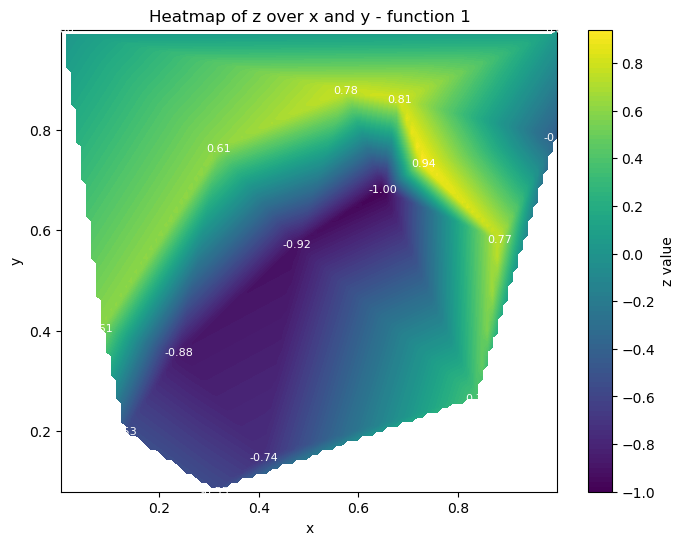

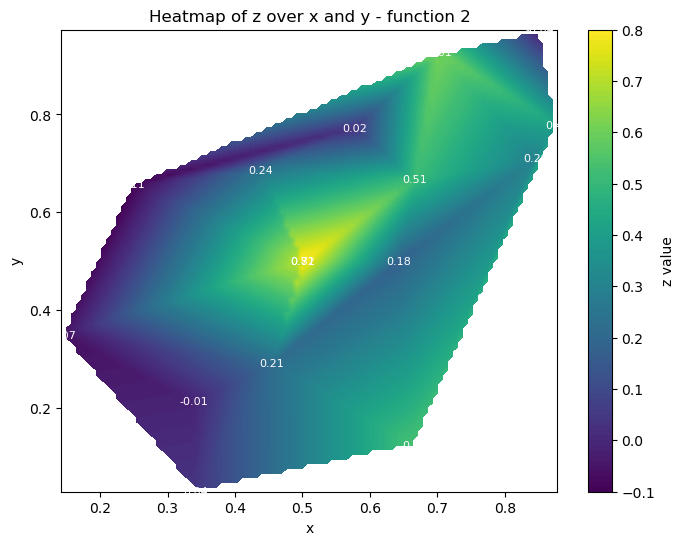

In [7]:
from scipy.interpolate import griddata

for i in range(1,3): #heatmaps of 2d functions
    ary_in, ary_out = get_function_data(i)
    x = ary_in[:, 0]
    y = ary_in[:, 1]
    z = ary_out

    if i==1:
        z = scale_f1(z) #apply scaling to f1 because of small values

    grid_x, grid_y = np.meshgrid(
        np.linspace(x.min(), x.max(), 100),
        np.linspace(y.min(), y.max(), 100)
    )

    # Interpolate the z values onto the grid
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='linear')
    #grid_z = np.log10(-grid_z)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    plt.contourf(grid_x, grid_y, grid_z, levels=100, cmap='viridis')
    plt.colorbar(label='z value')
    for xi, yi, zi in zip(x, y, z):
        plt.text(xi, yi, f'{zi:.2f}', color='white', fontsize=8, ha='center', va='center')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Heatmap of z over x and y - function {i}')
    plt.show()

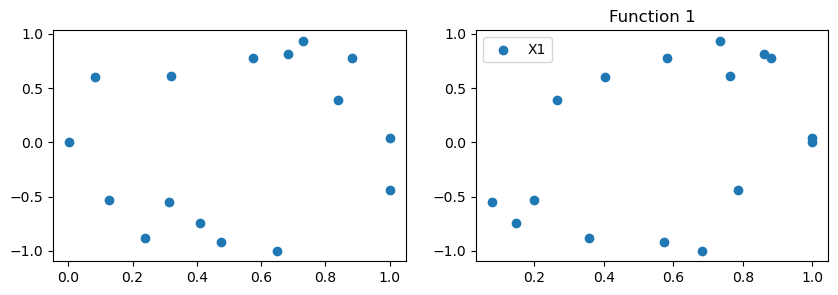

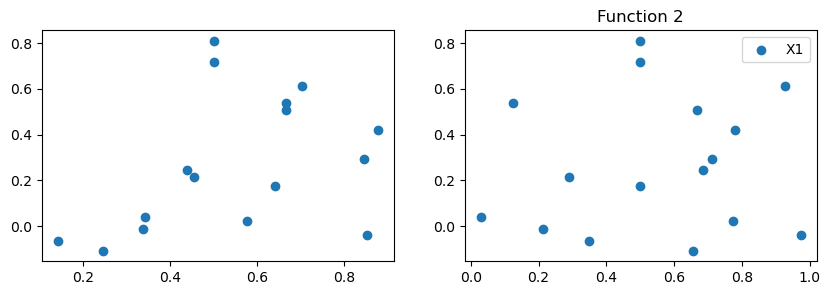

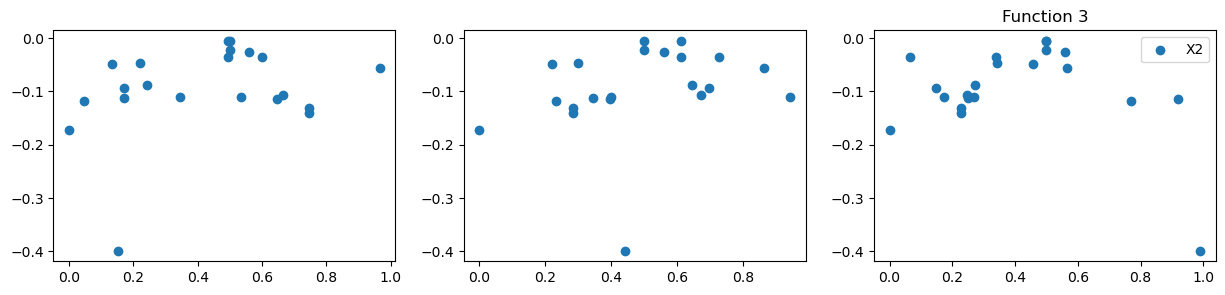

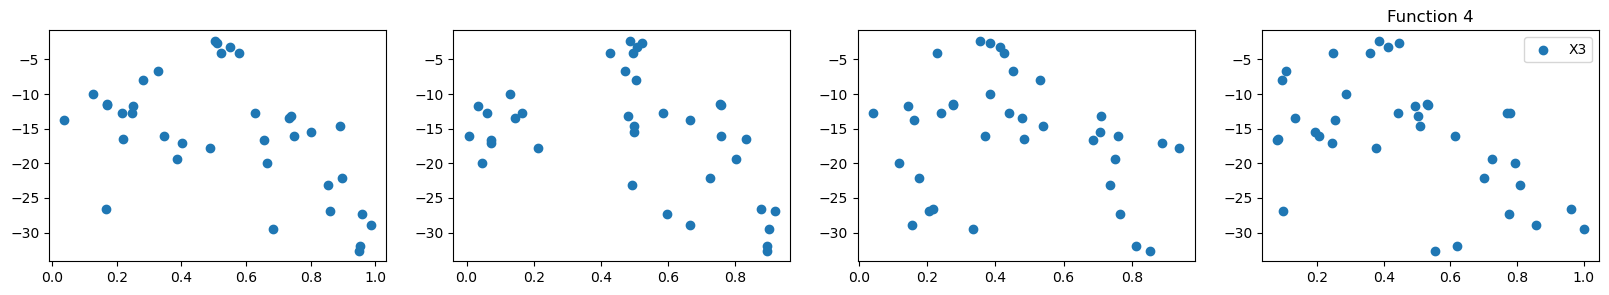

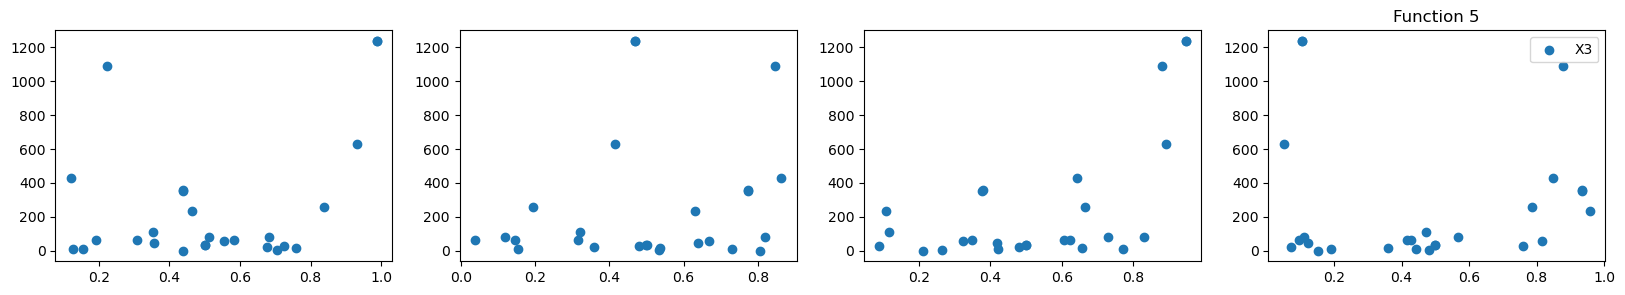

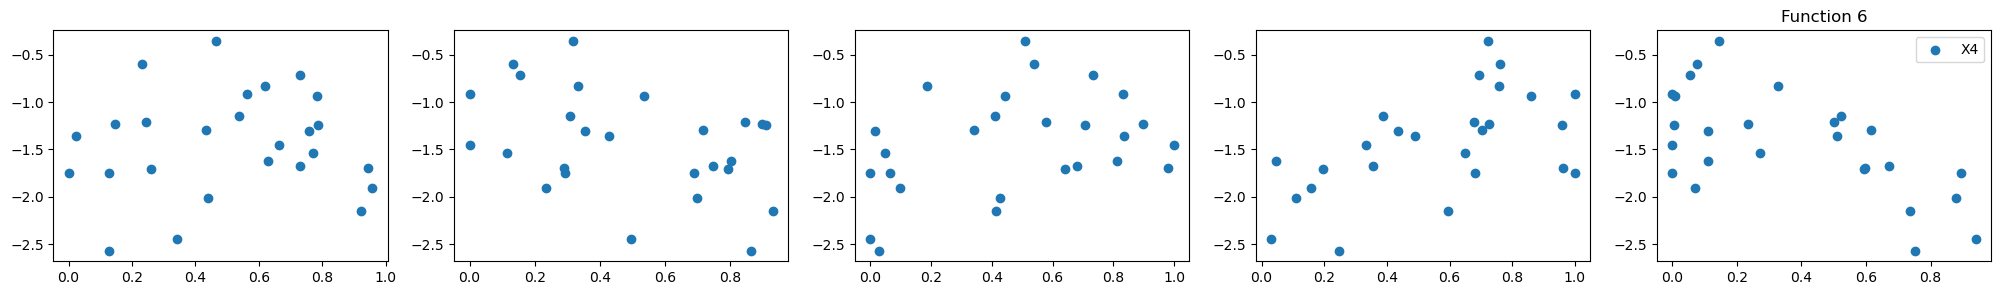

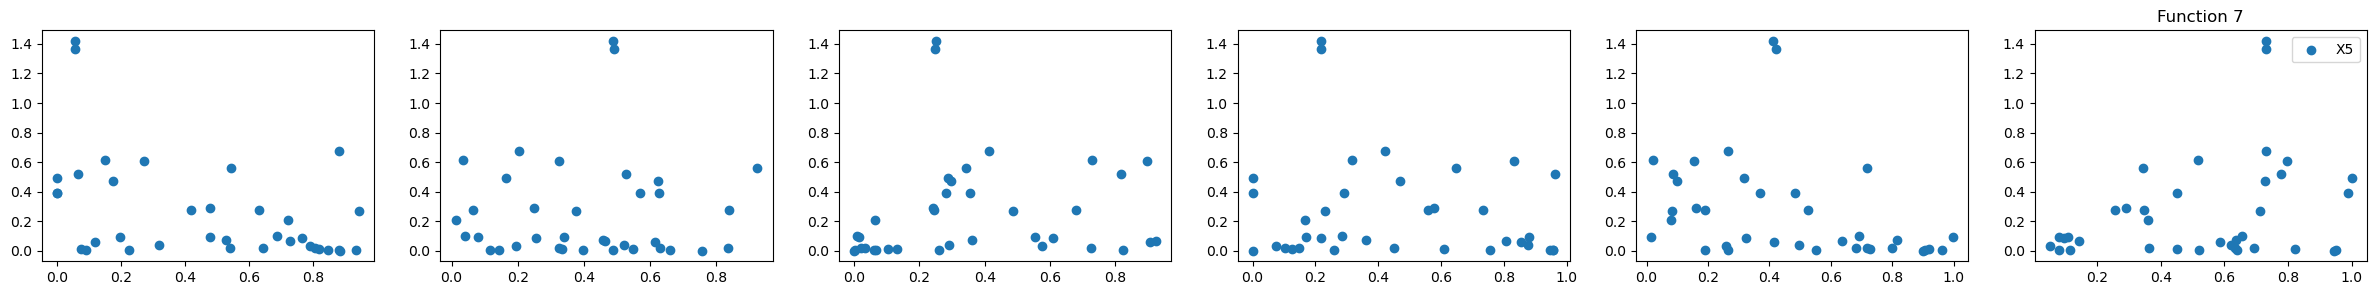

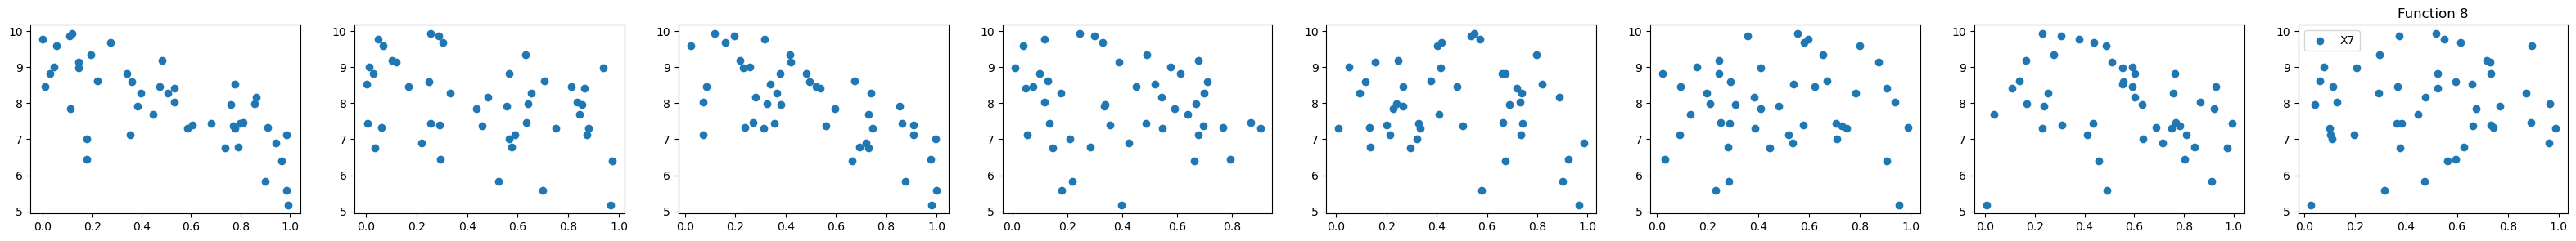

In [6]:



#Individual plot per parameter
for i in range(1,9):
    ary_in, ary_out = get_function_data(i)
    dimensions = ary_in.shape[1]
    fig, axes = plt.subplots(nrows=1, ncols=dimensions, figsize=(5 * dimensions, 3))
    if i==1:
        ary_out = scale_f1(ary_out) #apply scaling to f1 because of small values
    #fig.tight_layout()
    for x in range(0, dimensions):
        # sub = fig.add_subplot(1, dimensions, x+1)
        #sub.
        axes[x].scatter(ary_in[:, x], ary_out, label=f'X{x}')
        #sub.scatter(ary_in[:, x], ary_out, label=f'X{x}')
        #sub.xlabel(f'X{x}')
        #sub.ylabel('Output')
        # sub.title = f'Function {i} input {x}'
        #plt.savefig(f'../reports/figures/function_{i}_X{x}_vs_output.png')
    plt.title(f'Function {i}')    
    plt.legend()
    plt.show()

In [8]:
def create_n_dimensional_grid(dimensions, num_points = 1001):
    """
    Create a grid for n dimensions.
    
    Parameters:
    - dimensions: number of dimensions (n)
    - num_points: number of points along each axis
    
    Returns:
    - A 2D array of shape (n_points, n_dimensions) where each row is a point in the n-dimensional space.
    """
    # Create a list of n-dimensional grids in range 0-1
    grids = [np.linspace(0, 1, num_points) for _ in range(dimensions)]
    
    # Create the n-dimensional meshgrid and then stack the ravel-ed grids together
    meshgrid = np.meshgrid(*grids)
    
    # Flatten the meshgrid and stack it together to get a 2D array of shape (n_points, n_dimensions)
    X_grid = np.vstack([g.ravel() for g in meshgrid]).T
    
    return X_grid

In [9]:
# Gaussian Process Acquisition Function (Upper Confidence Bound)
def ucb_acquisition(x, model, kappa=2.0):
    """
    UCB acquisition function for Bayesian Optimization.
    
    Parameters:
    - x: Point at which to evaluate the acquisition function.
    - model: GaussianProcessRegressor model.
    - kappa: Controls the exploration vs exploitation trade-off.
    
    Returns:
    - UCB acquisition value at point x.
    """
    # Predict the mean and standard deviation
    mean, std = model.predict(x.reshape(1, -1), return_std=True)
    
    # UCB acquisition function
    return mean + kappa * std

def lcb_acquisition(x, model, kappa=2.0):
    mean, std = model.predict(x.reshape(1, -1), return_std=True)
    return mean - kappa * std

# Function to suggest the next query point
def suggest_next_point(bounds, function_number, model, kappa=2.0):
    """
    Suggest the next point to query using Bayesian Optimization with Gaussian Process.
    
    Parameters:
    - X_existing: Array of input points already observed (n_samples, n_features).
    - Y_existing: Array of corresponding output values (n_samples,).
    - bounds: Bounds for each input dimension (n_features, 2).
    - model: Pre-trained GaussianProcessRegressor model (if available).
    - kappa: Exploration-exploitation trade-off parameter for UCB.
    
    Returns:
    - Next input point to query.
    """

    # Define the acquisition function to minimize (negative UCB)
    def acquisition_wrapper(x):
        if function_number in [1,2,5,7,8]: #maximise
            return -ucb_acquisition(x, model, kappa)
        elif function_number == 4: # minimise
            return lcb_acquisition(x, model, kappa) 
        else:
            # closest to 0. Get highest abs of (ucb or lcb) and minimize that
            return max(abs(lcb_acquisition(x, model, kappa)), abs(ucb_acquisition(x, model, kappa)))  # Minimize the negative of the acquisition function
    
    # Minimize the acquisition function to find the next point
    start_point = np.random.uniform(bounds[:, 0], bounds[:, 1])
    #print (f"Start point = {start_point}")
    res = optimize.minimize(acquisition_wrapper, start_point, bounds=bounds, method='L-BFGS-B')
    
    # Return the next query point
    return res.x

def at_bound(x):
    if (0 in x) or (1 in x):
        return True
    return False

# Suggest next points for each function
for i in range(1,9):
    ary_in, ary_out = get_function_data(i)
    in_bounds = np.array([[0.0, 1.0]] * ary_in.shape[1])

    # fit gaussian process surrogate function
    kernel = RBF(length_scale=0.1, length_scale_bounds='fixed')
    #kernel = RationalQuadratic(length_scale=0.1, alpha=1.0)

    noise_assumption = 1e-1 # noise assumption, a hyper-parameter
    surrogate = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)

    surrogate.fit(ary_in, ary_out)

    next_point = [0]
    while at_bound(next_point):
        next_point = suggest_next_point(in_bounds, i, surrogate, kappa=2)
        #print(f"Function {i} Considering next point: {next_point})")
    submit = format_for_submission(next_point)
    print (f"Function {i} Next point to submit: {submit}")    

Function 1 Next point to submit: 0.407426-0.459462
Function 2 Next point to submit: 0.403505-0.490617
Function 3 Next point to submit: 0.031119-0.888575-0.682375
Function 4 Next point to submit: 0.920303-0.560483-0.754863-0.787021
Function 5 Next point to submit: 0.758506-0.536377-0.655804-0.359997
Function 6 Next point to submit: 0.696577-0.718409-0.034297-0.785884-0.995966
Function 7 Next point to submit: 0.148882-0.512910-0.305068-0.447789-0.531591-0.088217
Function 8 Next point to submit: 0.156114-0.355166-0.840379-0.027094-0.771983-0.038278-0.821367-0.202728


In [10]:
#using skopt

from skopt import gp_minimize
from skopt.space import Real
from sklearn.gaussian_process.kernels import Matern

def surrogate_function(inputs):
    
    # Predict using the Gaussian Process surrogate model
    y_pred, stdev = gp.predict(np.atleast_2d(inputs), return_std=True)
    return y_pred[0]  # Minimizing

def make_search_space(dimensions):
    
    search_space = [Real(0.0, 1.0, name=f'x{i+1}') for i in range(dimensions)]
    return search_space

# [abs y/n], [-1 for maximise, 1 for minimise], acq_func, kappa
optimise_params = [
    [0, 1, "LCB", 10], #f1 - maximise exploration
    [0, 1, "LCB", 2], #f2 - maximise exploration - 
    [0, 1, "EI", 0], #f3 - measuring adverse reaction to drug. Surely 0 for all ingredients would minimise adverse reaction!
    [1, 1, "EI", 5], #f2 - minimize absolute value - maximise exploration - ideally would be LCB but that is returning the bounds
    [0, -1, "EI", 0], #f5 - unimodal (maximize exploitation) - maximise yield
    [1, 1, "EI", 0], #f6 - cake - minimise absolute value
    [0, 1, "LCB", 1], #f7
    [0, 1, "EI", 0] #f8
    ]

noise_level = 0.1

#for i in range(1,9):
for i in [7]:
    ary_in, ary_out = get_function_data(i)
    print("Shape of ary_in:", ary_in.shape)

    search_space = make_search_space(ary_in.shape[1])

    # Check if ary_in dimensions match the search space
    assert ary_in.shape[1] == len(search_space), (
        f"Input dimensions ({ary_in.shape[1]}) do not match the search space dimensions ({len(search_space)})."
    )

    kernel = Matern(nu=2.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

    gp.fit(ary_in, ary_out)

    p = optimise_params[i-1]
    ary_out_prepared = ary_out * p[1] # if we should maximise, negate the output values before minimising
    if p[0]: #Use absolute vals where appropriate
        ary_out_prepared = np.abs(ary_out_prepared)
    
    res = gp_minimize(
    func=surrogate_function,   # The objective function to minimize
    dimensions=search_space,  # The search space
    #acq_func="EI",           # Acquisition function (Expected Improvement)
    acq_func=p[2],
    kappa= p[3],    # High kappa favors exploration
    n_calls=ary_in.shape[0] * 2,               # Total number of queries allowed (including initial samples)
    x0=[list(x) for x in ary_in],             # Initial input samples
    y0=ary_out # Initial output samples (negated for maximization)
    )
    print(f"Function {i}")
    print("Best input values found:", res.x)
    print("Best output value observed:", res.fun)

    # Suggest the next point to evaluate
    suggested = np.array(res.x_iters[-1])
    print("Suggested next inputs to try:", format_for_submission(suggested))



Shape of ary_in: (31, 6)
Function 7
Best input values found: [0.8756120828494655, 0.7432457454118679, 0.0, 0.0, 1.0, 0.9290746674825612]
Best output value observed: -0.418419967669732
Suggested next inputs to try: 0.882386-0.734145-0.000000-0.000000-1.000000-0.922322
